# Introduction to Quantum Computing  
## Assignment 5 - Due March 21  
### Quantum algorithms with IBM-Q  

#### Instructions:  
- All problems below should be solved with Qiskit using a Jupyter notebook in the UVic Jupyter hub: [https://jhub-phys.uvic.ca](https://jhub-phys.uvic.ca).
- Once you’re done, submit your `.ipynb` file(s) to the A5 area in BrightSpace.

---
### Resources  
- [UVic Jupyter Hub](https://jhub-phys.uvic.ca)  
- [Qiskit Documentation](https://qiskit.org/documentation/)  
- [IBM Quantum Lab](https://quantum-computing.ibm.com/)


In [45]:
# Import usual python numerical library
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
%matplotlib inline

import subprocess

#this is so I can run the code on my computer without sharing my token online
#you can get your own token at https://quantum-computing.ibm.com/account
token = subprocess.run("echo $IBM_TOKEN", shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()

# Insert your token
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True, set_as_default=True)

# List the backends available to you. 
service = QiskitRuntimeService(channel="ibm_quantum")

# Load the backend with the fewest pending jobs
service_backend = service.backend("ibm_sherbrooke") # closest to me geographically but often super busy

for backend in service.backends(operational = True):
    if (backend.status().pending_jobs < service_backend.status().pending_jobs):
        service_backend = service.backend(backend.name)
    print(backend.name, ', n_qubits =', backend.configuration().n_qubits, 
          ', pending_jobs =', backend.status().pending_jobs)
print('Using backend:', service_backend.name)


ibm_brisbane , n_qubits = 127 , pending_jobs = 11
ibm_kyiv , n_qubits = 127 , pending_jobs = 5
ibm_sherbrooke , n_qubits = 127 , pending_jobs = 2
Using backend: ibm_sherbrooke


## 1. Quantum Cryptography (BB84)  
Write a Qiskit code that implements BB84 with 15 qubits. You will play Alice, and there is no eavesdropper.  

### (a) Simulated Bob  
- Use the `AerSimulator` to play Bob.
- State clearly the value of the one-time pad that you got.

### (b) Real Device Bob  
- Use a real quantum device of your choice to play Bob.
- Clearly state the one-time pad that you got.
- Does it agree with the one-time pad that Alice got?
- Does it make sense to interpret the device’s intrinsic noise as an eavesdropper?


In [10]:
# 1a. Implement BB84 protocol using AerSimulator. 
from qiskit_aer import AerSimulator

qubit_count = 15

# Generate Alice's bases, followed by the qubits (logical 0 or 1)
alice_bases = np.random.randint(2, size=qubit_count)
alice_bits = np.random.randint(2, size=qubit_count)

#note that the basis 0 corresponds to the computational basis, and 1 corresponds to the Hadamard basis

# Generate Bob's bases
bob_bases = np.random.randint(2, size=qubit_count)

print("Alice's bits:\t", alice_bits)
print("Alice's bases:\t", alice_bases)
print("Bob's bases:\t", bob_bases)


# Create a quantum circuit to represent the qubits

bb84 = QuantumCircuit(qubit_count, qubit_count)

# Alice prepares the qubits:
for i in range(qubit_count):
    if alice_bits[i] == 1:
        bb84.x(i) # |0> -> |1>, triggers iff. the bit is 1
    if alice_bases[i] == 1:
        bb84.h(i) # changes the measurement basis to the Hadamard basis if the basis is specified as logical 1.

# Bob Measures: 
for i in range(qubit_count):
    if bob_bases[i] == 1:
        bb84.h(i)

bb84.measure(range(qubit_count), range(qubit_count))

# Run the simulation
simulator = AerSimulator()
result = simulator.run(bb84).result()

# We need to figure out which qubits Bob measured in the same basis as Alice

private_key = ''
for i in range(qubit_count):
    if alice_bases[i] == bob_bases[i]:
        private_key += str(alice_bits[i]) # if the bases match, we can add the bit to the private key

# Print the results 
matches = ['✓' if alice_bases[i] == bob_bases[i] else '✗' for i in range(qubit_count)]
matches = ' '.join(matches)
print("Matches:\t ", matches,)

print("\nPrivate key:", private_key)




Alice's bits:	 [0 0 1 1 1 1 1 0 1 0 1 0 1 1 0]
Alice's bases:	 [1 1 1 1 1 0 0 0 1 0 1 1 1 0 1]
Bob's bases:	 [1 0 0 0 1 1 0 1 0 1 0 0 1 1 1]
Matches:	  ✓ ✗ ✗ ✗ ✓ ✗ ✓ ✗ ✗ ✗ ✗ ✗ ✓ ✗ ✓

Private key: 01110


In [11]:
# 1b. Implement BB84 protocol using real equipment. 
qubit_count = 15

# Generate Alice's bases, followed by the qubits (logical 0 or 1)
alice_bases = np.random.randint(2, size=qubit_count)
alice_bits = np.random.randint(2, size=qubit_count)

#note that the basis 0 corresponds to the computational basis, and 1 corresponds to the Hadamard basis

# Generate Bob's bases
bob_bases = np.random.randint(2, size=qubit_count)

print("Alice's bits:\t", alice_bits)
print("Alice's bases:\t", alice_bases)
print("Bob's bases:\t", bob_bases)


# Create a quantum circuit to represent the qubits

bb84 = QuantumCircuit(qubit_count, qubit_count)

# Alice prepares the qubits:
for i in range(qubit_count):
    if alice_bits[i] == 1:
        bb84.x(i) # |0> -> |1>, triggers iff. the bit is 1
    if alice_bases[i] == 1:
        bb84.h(i) # changes the measurement basis to the Hadamard basis if the basis is specified as logical 1.

# Bob Measures: 
for i in range(qubit_count):
    if bob_bases[i] == 1:
        bb84.h(i)

bb84.measure(range(qubit_count), range(qubit_count))


# We need to transpile the circuit to match the device, and then send it over to the device for execution
bb84_transpiled = transpile(bb84, service_backend)
# optimize the circuit
bb84_pass_manager = generate_preset_pass_manager(backend=service_backend, optimization_level=2)


# send the job to the device
isa_bb84 = bb84_pass_manager.run(bb84_transpiled)
from qiskit_ibm_runtime import SamplerV2
sampler = SamplerV2(service_backend)
result = sampler.run([isa_bb84], shots=1).result() # we only want one shot- to simulate the real world scenario running the protocol once in real-time. 


# We need to figure out which qubits Bob measured in the same basis as Alice

private_key = ''
for i in range(qubit_count):
    if alice_bases[i] == bob_bases[i]:
        private_key += str(alice_bits[i]) # if the bases match, we can add the bit to the private key

# Print the results 
matches = ['✓' if alice_bases[i] == bob_bases[i] else '✗' for i in range(qubit_count)]
matches = ' '.join(matches)
print("Matches:\t ", matches)

print("\nPrivate key:", private_key)


Alice's bits:	 [0 0 0 0 1 0 0 0 1 0 1 1 0 0 1]
Alice's bases:	 [1 1 1 1 0 0 0 1 0 1 1 0 0 0 0]
Bob's bases:	 [1 1 0 1 0 1 1 0 0 1 0 0 0 1 0]


Matches:	  ✓ ✓ ✗ ✓ ✓ ✗ ✗ ✗ ✓ ✓ ✗ ✓ ✓ ✗ ✓

Private key: 000110101


### Discussion

#### Does it agree with the one-time pad that Alice got?

Running the code with the AerSimulator, the one-time pad that Bob got was the same as the one-time pad that Alice got. This is expected since there is no eavesdropper in this case. 

Running on a real quantum device, the one-time pad that Bob got was also the same as the one-time pad that Alice got. This behaviour was observed both running a singe shot and multiple (8192) shots. This suggests that the device has adequate error-correction and noise mitigation techniques in place- the intrinsic noise of the device is not enough to cause a discrepancy between the one-time pads of Alice and Bob (at least for the number of qubits used in this case).

This experiment should be continued for a larger number of qubits to see if the intrinsic noise of the device starts to cause discrepancies between the one-time pads of Alice and Bob, and if so, at what point this occurs. This will form the basis of the "upper bound" tuning that Dr. De Sousa has mentioned in class.


#### Does it make sense to interpret the device’s intrinsic noise as an eavesdropper?

In this case, probably not. The device's intrinsic noise was not observed to produce discrepancies between the one-time pads of Alice and Bob. However, this is not always the case. 

In general, the intrinsic noise of a quantum device can be considered as an eavesdropper if it is causing discrepancies between the one-time pads of Alice and Bob. (Which would occur if an eavesdropper was intercepting and measuring qubits.) This is why it is important to run the BB84 protocol on a real quantum device to test its security, and calibrate the device to ensure that the intrinsic noise is not enough to cause discrepancies between the one-time pads of Alice and Bob, but ensure the detection of an eavesdropper if one is present.


## 2. Quantum Cloning  

### (a) Design a Quantum Cloning Circuit  
Design a quantum circuit that clones the states $|+\rangle$ and $|-\rangle$, i.e., design a unitary $ U $ that achieves the following:

$$
U (|+\rangle |0\rangle) = |+\rangle |+\rangle, \\
U (|-\rangle |0\rangle) = |-\rangle | -\rangle.
$$

### (b) Cloning Fidelity  
- Apply this $ U $ to $|0\rangle$ and $|1\rangle$.
- Evaluate the "cloning fidelity" by computing:

$$
F_{\psi} = |\langle\psi| \langle\psi| U (|\psi\rangle |0\rangle)|^2
$$

for $|\psi\rangle = |0\rangle$ and $|\psi\rangle = |1\rangle$ using the `AerSimulator`. How good is the cloning?


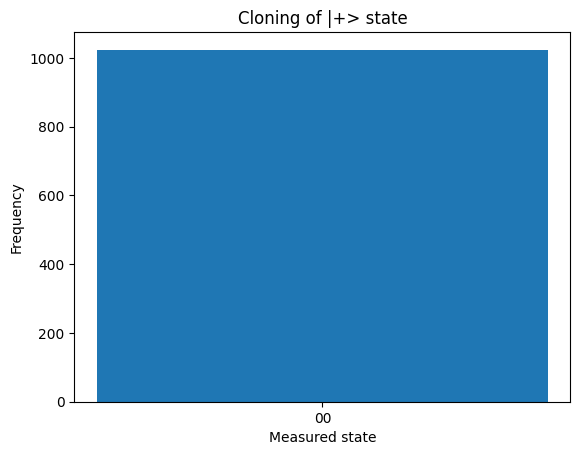

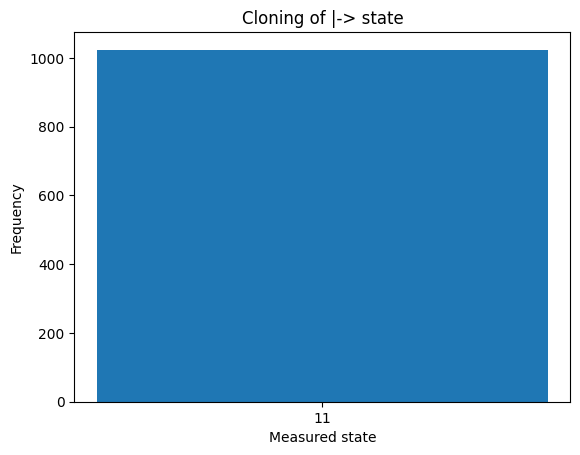

In [12]:
# 2a. Design (and implement) a quantum circuit that clones the state of a qubit in the Hadamard basis.

import matplotlib
import matplotlib.pyplot
%matplotlib inline

hadamardClone = QuantumCircuit(2, 0) 

# qubit 1 is the qubit to be cloned, qubit 0 is the blank qubit
hadamardClone.h(1) # take qubit 1 to the computational basis
hadamardClone.cx(1, 0) # if qubit 1 is in the state |1>, qubit 0 will be in the state |1>, (essentially copying the state)

hadamardClone.h(1) # take qubit 1 back to the Hadamard basis
hadamardClone.h(0) # take qubit 0 back to the Hadamard basis

hadamardClone.barrier(range(2))

# apply Hadamards to both gates to get deterministic results
hadamardClone.h(0)
hadamardClone.h(1)

hadamardClone.measure_all()

# Draw the designed Unitary
# hadamardClone.draw(reverse_bits=True, output='latex')

# Run the simulation for states |+>|0> and |->|0>
simulator = AerSimulator()

# Prepare states |+>|0> and |->|0>

prepare_plus = QuantumCircuit(2, 0) 
prepare_plus.h(1) # |0>|0> -> |+>|0>
prepare_plus.barrier(range(2))

prepare_minus = QuantumCircuit(2, 0)
prepare_minus.x(1) # |0>|0> -> |1>|0>
prepare_minus.h(1) # |1>|0> -> |->|0>
prepare_minus.barrier(range(2))

# Run 1. (State |+>|0>)
hadamardClone_plus = QuantumCircuit.compose(prepare_plus, hadamardClone, range(2), range(2))
hadamardClone_plus.draw(reverse_bits=True, output='latex')
result_plus = simulator.run(hadamardClone_plus).result()

# Plot the results, showing the deterministic state of the cloned qubit (expecting |00> to correspond with cloned |++>).
counts_plus = result_plus.get_counts()
matplotlib.pyplot.bar(counts_plus.keys(), counts_plus.values())
matplotlib.pyplot.xlabel('Measured state')
matplotlib.pyplot.ylabel('Frequency')
matplotlib.pyplot.title('Cloning of |+> state')
matplotlib.pyplot.show()


# Run 2. (State |->|0>)
hadamardClone_minus = QuantumCircuit.compose(prepare_minus, hadamardClone, range(2), range(2))
hadamardClone_minus.draw(reverse_bits=True, output='latex')
result_minus = simulator.run(hadamardClone_minus).result()

# Plot the results, showing the deterministic state of the cloned qubit (expecting |11> to correspond with cloned |-->).
counts_minus = result_minus.get_counts()
matplotlib.pyplot.bar(counts_minus.keys(), counts_minus.values())
matplotlib.pyplot.xlabel('Measured state')
matplotlib.pyplot.ylabel('Frequency')
matplotlib.pyplot.title('Cloning of |-> state')
matplotlib.pyplot.show()








In [13]:
# 2b. [Cloning Fidelity] Apply the cloning unitary to states |00> and |10> and measure the fidelity of the cloned states with the original states.
# This will use the given equation in the problem statement. 

# Prepare states |00> and |10>
prepare_00 = QuantumCircuit(2, 0)
prepare_00.barrier(range(2))

prepare_10 = QuantumCircuit(2, 0)
prepare_10.x(1) # |00> -> |10>

# Run 1. (State |00>)
hadamardClone_00 = QuantumCircuit.compose(prepare_00, hadamardClone, range(2), range(2))
hadamardClone_00.save_statevector()
result_00 = simulator.run(hadamardClone_00).result()
# print(result_00.get_statevector())

# Calculate the fidelity

# F = |<0<0|U(|0>|0>)|^2

ket_00 = np.array([0, 0, 0, 0])

fidelity_00 = np.abs(np.dot(ket_00.conj(), result_00.get_statevector() ))**2
print("Fidelity of |00>:", fidelity_00)

# Run 2. (State |10>)
hadamardClone_10 = QuantumCircuit.compose(prepare_10, hadamardClone, range(2), range(2))
hadamardClone_10.save_statevector()
result_10 = simulator.run(hadamardClone_10).result()
# print(result_10.get_statevector())

# Calculate the fidelity

# F = |<1<0|U(|1>|0>)|^2

ket_10 = np.array([0, 0, 1, 0])

fidelity_10 = np.abs(np.dot(ket_10.conj(), result_10.get_statevector()))**2
print("Fidelity of |10>:", fidelity_10)



Fidelity of |00>: 0.0
Fidelity of |10>: 0.0


### Discussion
\[Cloning Fidelity\] The fidelity of cloning $\ket{0}$ and $\ket{1}$ in using my unitary $U$ designed for the Hadamard basis yielded a fidelity of $0.0$. This is to be expected, as the two bases (Computational and Hadamard) are orthogonal. The result implies that the cloning unitary (as designed) is terrible on other (non-hadamard) bases, with the worst performance on the orthogonal computational basis. 


## 3. One-Qubit Tomography  
Write the three circuits necessary to measure the projections of the state:

$$
|\psi\rangle = \cos\left(\frac{\pi}{8}\right) |0\rangle + \sin\left(\frac{\pi}{8}\right) |1\rangle,
$$

along the x, y, and z axes of the Bloch sphere.

- Do this for the simulator and for a real device using **1000 shots**.
- Use the function `plot_bloch_vector([px,py,pz])` to display the Bloch vectors.
- How do they compare?



Expectation values (statevector): 0.7071067811865476 0.0 0.7071067811865475


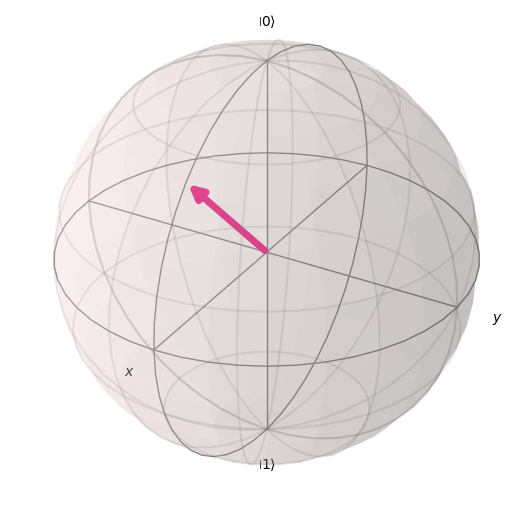

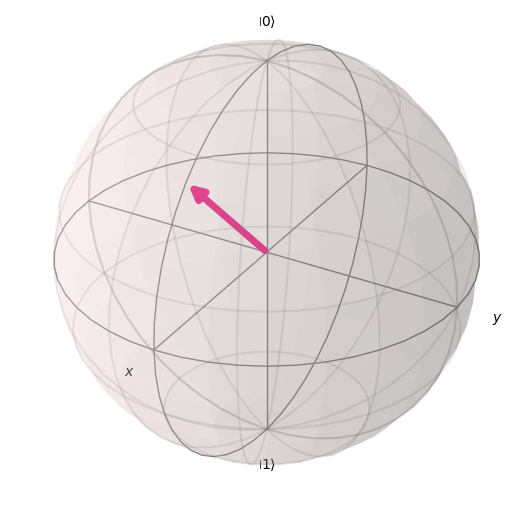

In [4]:
# [One-Qubit Tomography] essentially, just plot \ket{\psi} in the Bloch sphere. Do this in the simulator and on a real device. 

# Here's the plan: 
# 1. Generate the state \ket{\psi} as defined in the problem definition.
# 2. do <psi|U|psi> on each of the pauli matrices to get the expectation values on each of the axes of the Bloch sphere. 
# Note: this is where "real device" and "simulator" will differ, as we should expect some noise running U|psi> on a real device. 
# 3. Expectation values in hand, we can plot the Bloch vectors. 
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer import AerSimulator


# Simulating the output using Qiskit.quatum_info.Statevector
psi_generator = QuantumCircuit(1, 1)
psi_generator.ry(np.pi/4, 0) # |0> -> |psi>
psi_generator.barrier(range(1))
state_psi = Statevector.from_instruction(psi_generator)

expectation_x = state_psi.expectation_value(Pauli('X'))
expectation_y = state_psi.expectation_value(Pauli('Y'))
expectation_z = state_psi.expectation_value(Pauli('Z'))

print("Expectation values (statevector):", expectation_x, expectation_y, expectation_z)

# Plot the Bloch vector
from qiskit.visualization import plot_bloch_vector
plot_bloch_vector([expectation_x, expectation_y, expectation_z])


Expectation values (Aer): 0.7071067811865476 0.0 0.7071067811865475


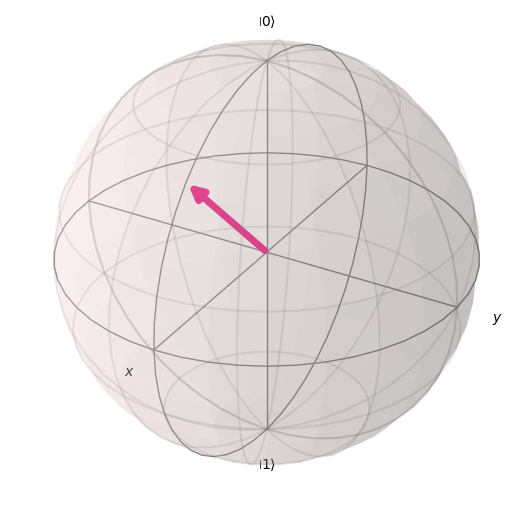

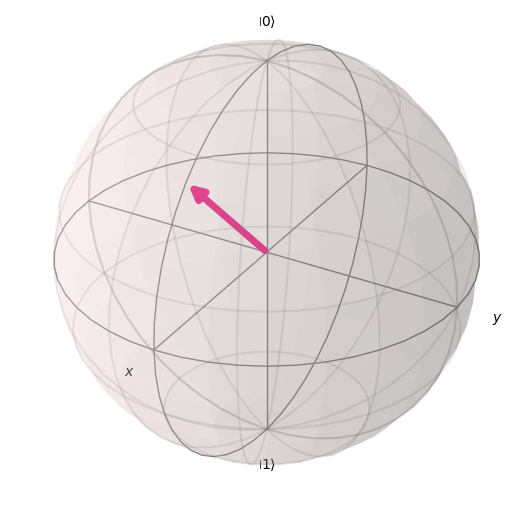

In [5]:
# Defining the circuit to run on the real device (or simulator) 
circ_x = QuantumCircuit.copy(psi_generator)
circ_x.x(0) # apply the X gate to the qubit, performing X|psi>
circ_x.save_statevector() # we need this to perform the expectation value calculation

circ_y = QuantumCircuit.copy(psi_generator)
circ_y.y(0) # apply the Y gate to the qubit, performing Y|psi>
circ_y.save_statevector() # we need this to perform the expectation value calculation

circ_z = QuantumCircuit.copy(psi_generator)
circ_z.z(0) # apply the Z gate to the qubit, performing Z|psi>
circ_z.save_statevector() # we need this to perform the expectation value calculation

# Run the circuits on the simulator
simulator = AerSimulator()

expectation_x = simulator.run(circ_x).result().get_statevector().expectation_value(Pauli('X'))
expectation_y = simulator.run(circ_y).result().get_statevector().expectation_value(Pauli('Y'))
expectation_z = simulator.run(circ_z).result().get_statevector().expectation_value(Pauli('Z'))

print("Expectation values (Aer):", expectation_x, expectation_y, expectation_z)

plot_bloch_vector([expectation_x, expectation_y, expectation_z])

Expectation values (Real Hardware): [0.67921605 0.03718336 0.68417383]


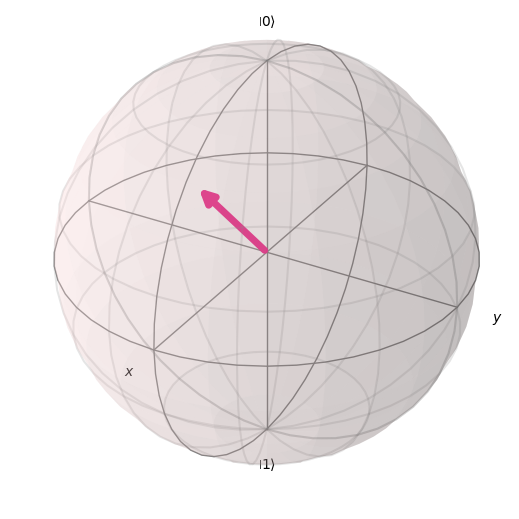

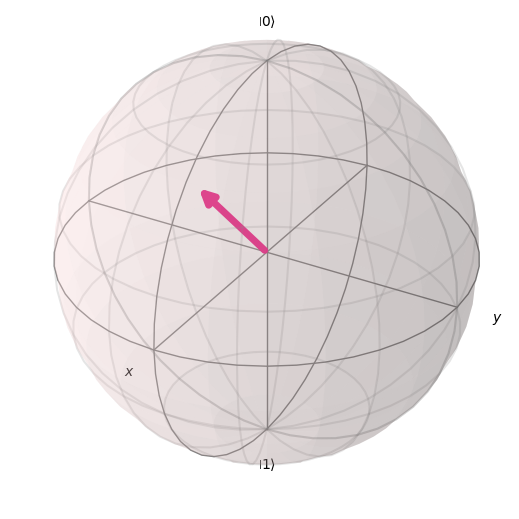

In [46]:
from qiskit_ibm_runtime import EstimatorV2
from qiskit.compiler import transpile
from qiskit.quantum_info import Pauli


# The below code is adapted from the example provided in the Qiskit documentation.
# https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/estimator-v2

psi = psi_generator

# Transpile the circuit to match the device
pm = generate_preset_pass_manager(backend=service_backend, optimization_level=1)
isa_psi = pm.run(psi)

# Define the observables
isa_observables = []
isa_observables.append(Pauli('X').apply_layout(isa_psi.layout))
isa_observables.append(Pauli('Y').apply_layout(isa_psi.layout))
isa_observables.append(Pauli('Z').apply_layout(isa_psi.layout))


 
estimator = EstimatorV2(mode=service_backend, options={"default_shots": 1000})
 
# calculate [ <psi|hamiltonian|psi> ]
job = estimator.run([(isa_psi, isa_observables)])
pub_result = job.result()[0]
print(f"Expectation values (Real Hardware): {pub_result.data.evs}")

plot_bloch_vector(pub_result.data.evs)


### Discussion. 

We see that the projections along the x, y, and z axes of the Bloch sphere (in both simulator and real device) are consistent with our expectations for the state $|\psi\rangle$. (That is, we expected to see the state $\ket{0}$ being rotated over the y-axis by $\frac{\pi}{4}$). 

The Bloch vectors for the simulator and real device are very similar, with discrepancies likely due to the intrinsic noise of the real device. The Bloch vectors for the real device are slightly more "noisy" than the simulator, but the direction of the Bloch vectors are consistent with the expected values.

## 4. Error Correction with the Three-Qubit Bit-Flip Code  

The circuit shown below is the “automated” version of the three-qubit bit-flip error correction code described in class. The last five gates – Two CNOTs and three Toffolis – perform the same **correction protocol** achieved by the conditional measurement operations shown in class.

- The final state $|\Phi\rangle$ of the ancillas remains $|00\rangle$ if no error happens.
- It becomes $|10\rangle, |11\rangle, |01\rangle$ when one of the qubits 2, 1, 0 flips, respectively.
- If another round of error correction is needed, the ancilla state $|\Phi\rangle$ must be reset to $|00\rangle$.

### (a) Implement the Algorithm  
- Implement the algorithm for:

$$
|\psi_{\text{in}}\rangle = \frac{1}{\sqrt{2}} (|000\rangle + |111\rangle)
$$

- In the simulator, check that it works by intentionally flipping each one of the three qubits in $|\psi_{\text{in}}\rangle$ before the error correction procedure.
- Measure $|\psi_{\text{out}}\rangle$ in the computational basis and check that you get close to 50% probability for **000** and **111**.

### (b) Run on a Real Device  
- Run the same circuit in a **real device** (no need to add intentional flips!).
- Measure $|\psi_{\text{out}}\rangle$. How good is it?

### (c) Compare Without Error Correction  
- Run the same algorithm in the same real device **without** the last five “correction protocol” gates.
- How do the computational basis probabilities for $|\psi_{\text{out}}\rangle$ compare to those found in item (b)?
- Conclude whether the device has low enough noise to benefit from error correction.


## 5. Three-Bit Phase Estimation  

### (a) Implement Phase Estimation  
Implement the circuit below for $ U = R_y(\theta) $ with:

$$
\frac{\theta}{4\pi} = 0.j_1j_2j_3,
$$

where **$ j_1j_2j_3 $** is your choice of three base-2 decimals.

- Note that $ \frac{\theta}{4\pi} $ is the associated phase **$ \phi_u $** for $|u\rangle = |-i\rangle$, since:

$$
R_y(\theta) |-i\rangle = e^{+i\frac{\theta}{2}} |-i\rangle = e^{+2\pi i \frac{\theta}{4\pi}} |-i\rangle.
$$

- Input $|\psi\rangle = |-i\rangle$.
- Run the circuit in **both the simulator and a real device** to compare.

### (b) Small Perturbation  
- Run the circuit again for $ \frac{\theta}{4\pi} = 0.j_1j_2j_3 - \epsilon $, with **$ \epsilon $** small.
- If you run the circuit many times, does it return the **$ 0.j_1j_2j_3 $** closest to the correct answer **$ \frac{\theta}{4\pi} $**?
- How does the real device compare to the simulator?

